In [2]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
#from ncplot import view
# supressing the ncplot warnings
import warnings
warnings.filterwarnings('ignore')

# Refractivity Calculation

First lets write the wet refraction formula,

$N_w$ = $\frac{k_2'  p_w  Z_w^{-1}}{T}$ + $\frac{k_3  p_w  Z_w^{-1}}{T^2}$

Python code for $Z_w^{-1}$, the inverted wet compressibility from Owens (1967):

In [3]:
def invZw(p_wet, T):
    inv_Zw = 1 + 1650*(p_wet/T**3)*(1-0.01317*(T-273.15) +  (1.75e-4)*(T-273.15)**2 + (1.44e-6)*(T-273.15)**3)
    return inv_Zw

Python code for $N_w$, the wet refractivity:

In [97]:
def Nw(p_wet, T, inv_Zw, k2prime, k3):
    N = (k2prime*p_wet*inv_Zw/T) + (k3*p_wet*inv_Zw/(T**2))
    return N

Python code for $k_2'$:

In [5]:
def k2prime(k1, k2, M_w = 18.01528, M_d = 28.9647):
    k2prime = k2 - k1*(M_w/M_d)
    return k2prime

In [6]:
k1 = 77.6900 # K/hPa varies negligibly with atmosphericc carbon dioxide concentration
k2 = 71.2952 # K/hPa
k3 = 375463 # K^2/hPa

In [7]:
# Molar masses are constant up until > 100 km
M_w = 18.01528 # Molar mass of water vapour in g/mol
M_d = 28.9647 # Molar mass of dry air in g/mol

In [8]:
k2prime = k2prime(k1, k2)

So what we need for us to calculate the wet refractivity through the troposphere is the T and the partial pressure of water vapour at different altitudes (or air pressure levels).
Barra, gives the relative humidity at 37 pressure levels every hour, from this can we calculate the partial pressure of water vapour?

Relative Humidity = partial pressure of water vapour / saturation vapour pressure?

If so, then saturation vapur pressure is a function of temperature, so this can be calculated at each level! However there is no analytical solution for this? Just estimations or numerical solutions it seems.

For now we will use the Magnus approximation outlined in the Boehm book

In [9]:
def saturationVapourPres(T):
    T_cel = T - 273
    E = 6.1078*np.exp((17.1*T_cel)/(235+T_cel))
    return E

In [10]:
def partialPressureVapour(rel_humidity, satVapPres):
    p_w = rel_humidity*satVapPres
    return p_w

I think we now have everything we need to calculate the refractivity at each of the 37 pressure levels in the BARRA dataset.

# Explore BARRA sample data

In [14]:
# Data is divided into 6 hour chunks for each day, labelled 0000Z, 0600Z, 1200Z, 1800Z
# Exploring the air_temp 0000Z sample data
ds = nc.Dataset('air_temp-fc-prs-PT1H-BARRA_TA-v1-20150207T0000Z.nc')

In [15]:
# Print all the variables contained in the air_temp dataset
for var in ds.variables.values():
    print(var)

<class 'netCDF4._netCDF4.Variable'>
int32 latitude_longitude()
    grid_mapping_name: latitude_longitude
    longitude_of_prime_meridian: 0.0
    earth_radius: 6371229.0
    MD5: c8ed20c23ba91f4577f84c940c86c7db
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used
<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    axis: T
    units: hours since 1970-01-01 00:00:00
    standard_name: time
    calendar: gregorian
    long_name: time
    MD5: eb349867a0f5b2610578751204ed59cb
unlimited dimensions: 
current shape = (7,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 pressure(pressure)
    axis: Z
    units: hPa
    long_name: pressure
    MD5: 42c5cf40497fbc44494688d1aaa796f5
unlimited dimensions: 
current shape = (37,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    axis: Y
    units: degrees_north
    stan

In [16]:
# Print the times for the data
ds['time'][:] # 7 time values for 0, 1, 2, 3, 4, 5, 6 hours in the 6 hour netcdf data file

masked_array(data=[395355., 395356., 395357., 395358., 395359., 395360.,
                   395361.],
             mask=False,
       fill_value=1e+20)

In [17]:
# Air_temp array, for each time stamp, there are 37 sub-arrays (1 for each pressure level), 
# each with 508 arrays (individual lat values) that each have 594 longitude values
#ds['air_temp'][1][0][0]

Data structure for a given parameter is: dataset[VAR_name][time_index][pressure_index][lat_index][lon_index] 

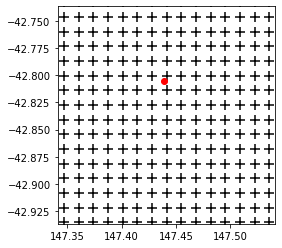

In [18]:
# rough MtP coords: -42.80500 deg lat, 147.439167 deg long

fig = plt.figure()
ax = fig.add_subplot(111)

for lat in ds['latitude']:
    lat_array = np.empty(len(ds['longitude']))
    lat_array.fill(lat)
    plt.scatter(ds['longitude'][:], lat_array, color='k', marker='+',s=100)
    plt.xlim([147.3411,147.5411])
    plt.ylim([-42.9367,-42.7367])
plt.scatter(147.439167, -42.80500, color='r')
ax.set_aspect('equal', adjustable='box')

In [19]:
ds['pressure'][:]

masked_array(data=[1.00e-01, 2.00e-01, 3.00e-01, 5.00e-01, 7.00e-01,
                   1.00e+00, 2.00e+00, 3.00e+00, 5.00e+00, 7.00e+00,
                   1.00e+01, 2.00e+01, 3.00e+01, 5.00e+01, 7.00e+01,
                   1.00e+02, 1.50e+02, 1.75e+02, 2.00e+02, 2.25e+02,
                   2.50e+02, 2.75e+02, 3.00e+02, 3.50e+02, 4.00e+02,
                   4.50e+02, 5.00e+02, 6.00e+02, 7.00e+02, 7.50e+02,
                   8.00e+02, 8.50e+02, 9.00e+02, 9.25e+02, 9.50e+02,
                   9.75e+02, 1.00e+03],
             mask=False,
       fill_value=1e+20)

In [21]:
ds_geopht = nc.Dataset('geop_ht-fc-prs-PT1H-BARRA_TA-v1-20150207T0000Z.nc')

In [22]:
np.mean(ds_geopht['geop_ht'][2][0][:])

56648.23

Find which long and lat index is closest to MtP.

In [28]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

lat_idx = find_nearest(ds['latitude'], -42.80500)
lon_idx = find_nearest(ds['latitude'], 147.439167)

In [58]:
# playing around with data, these are the air temp values above Mt.P for all 37 pressure values, for the first time.
ds['air_temp'][0, :, lat_idx, lon_idx]

masked_array(data=[261.375, 261.375, 261.375, 261.375, 261.375, 261.375,
                   261.375, 261.375, 250.   , 242.625, 235.625, 227.375,
                   220.875, 212.375, 208.5  , 207.625, 215.875, 218.375,
                   217.25 , 218.75 , 224.   , 229.125, 233.75 , 242.125,
                   249.25 , 255.625, 261.   , 269.   , 278.   , 282.375,
                   286.875, 290.5  , 293.5  , 294.125, 294.25 , 292.75 ,
                   290.375],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

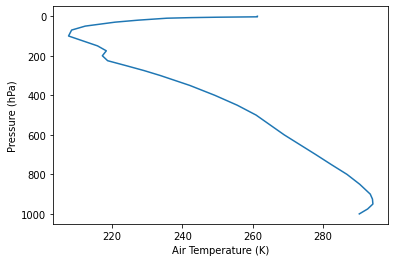

In [67]:
plt.plot(ds['air_temp'][0, :, lat_idx, lon_idx], ds['pressure'][:])
plt.ylabel('Pressure (hPa)')
plt.xlabel('Air Temperature (K)')
plt.gca().invert_yaxis()
plt.show()

In [60]:
# lets get the corresponding geopotential heights
ds_geopht['geop_ht'][0,:,lat_idx, lon_idx]

masked_array(data=[56651., 54432., 52915., 50737., 49118., 47223., 42941.,
                   40013., 36207., 33734., 31291., 26634., 23980., 20730.,
                   18674., 16515., 14007., 13023., 12171., 11424., 10743.,
                   10111.,  9521.,  8447.,  7487.,  6616.,  5818.,  4399.,
                    3163.,  2596.,  2057.,  1543.,  1053.,   817.,   586.,
                     362.,   145.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

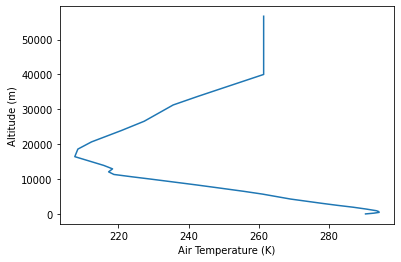

In [65]:
plt.plot(ds['air_temp'][0, :, lat_idx, lon_idx], ds_geopht['geop_ht'][0,:,lat_idx, lon_idx])
plt.ylabel('Altitude (m)')
plt.xlabel('Air Temperature (K)')
#plt.gca().invert_yaxis()
plt.show()

# Calculate refractivity through atmosphere

In [69]:
# Load data
ds_air_temp = nc.Dataset('air_temp-fc-prs-PT1H-BARRA_TA-v1-20150207T0000Z.nc')
ds_relhum = nc.Dataset('relhum-fc-prs-PT1H-BARRA_TA-v1-20150207T0000Z.nc')
ds_geop_ht = nc.Dataset('geop_ht-fc-prs-PT1H-BARRA_TA-v1-20150207T0000Z.nc')

In [118]:
# just consider doing this for a single time (index 0)
air_temp = ds_air_temp['air_temp'][0, :, lat_idx, lon_idx]
rel_hum = ds_relhum['relhum'][0, :, lat_idx, lon_idx]/100 # need fractional
geop_ht = ds_geop_ht['geop_ht'][0, :, lat_idx, lon_idx]

In [119]:
N_values = []
for i in range(0,len(air_temp)):
    T = air_temp[i]
    E = saturationVapourPres(T)
    p_wet = partialPressureVapour(rel_hum[i], E)
    inv_Zw = invZw(p_wet, T)
    N_wet = Nw(p_wet, T, inv_Zw, k2prime, k3)
    N_values.append(N_wet)

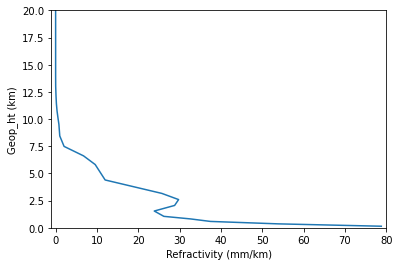

In [120]:
plt.plot(N_values, geop_ht/1000)
plt.ylabel('Geop_ht (km)')
plt.xlabel('Refractivity (mm/km)')
plt.gca().invert_yaxis()
plt.ylim([0, 20])
plt.xlim([-1, 80])
plt.show()

# Testing ncplot

In [ ]:
#view('C:/Users/Tiege/Documents/research/BARRA/SAMPLE/relhum-fc-prs-PT1H-BARRA_TA-v1-20150207T0000Z.nc')

In [101]:
invZw(partialPressureVapour(rel_hum[:], saturationVapourPres(air_temp)), air_temp)

masked_array(data=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
                   1.0000032186508179, 1.000003457069397, 1.0000079870224,
                   1.0000108480453491, 1.000012755393982,
                   1.0000159740447998, 1.000065803527832,
                   1.0003681182861328, 1.0007497072219849,
                   1.0012730360031128, 1.0019375085830688,
                   1.002504825592041, 1.00275719165802, 1.004962682723999,
                   1.0146034955978394, 1.0187735557556152,
                   1.0203607082366943, 1.0375573635101318,
                   1.0407013893127441, 1.0370863676071167,
                   1.0294979810714722, 1.0314468145370483,
                   1.038973331451416, 1.0446804761886597,
                   1.0650980472564697, 1.0974420309066772],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False

In [103]:
N_values

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.09134215461629636,
 0.09102652661670159,
 0.18544191063255572,
 0.23821765627768568,
 0.277457891182264,
 0.38524427084540297,
 1.648007293957824,
 9.081294442638535,
 18.898116582021373,
 34.68177039821446,
 57.141104108279855,
 79.57739641665874,
 100.76960850306313,
 205.85507078140853,
 685.579814542265,
 975.3199461777649,
 1222.264020582792,
 2665.911396477636,
 3095.2047819813865,
 2984.855898854704,
 2456.5920163513706,
 2700.459962627458,
 3389.1275622586168,
 3910.7976498393405,
 5734.121085195171,
 8639.167268097604]

In [104]:
geop_ht

masked_array(data=[56651., 54432., 52915., 50737., 49118., 47223., 42941.,
                   40013., 36207., 33734., 31291., 26634., 23980., 20730.,
                   18674., 16515., 14007., 13023., 12171., 11424., 10743.,
                   10111.,  9521.,  8447.,  7487.,  6616.,  5818.,  4399.,
                    3163.,  2596.,  2057.,  1543.,  1053.,   817.,   586.,
                     362.,   145.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [106]:
rel_hum

masked_array(data=[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
                    0.   ,  0.   ,  0.   ,  0.   ,  0.125,  0.25 ,  1.375,
                    2.875,  3.75 ,  1.875,  6.   , 37.625, 65.875, 67.625,
                   65.25 , 57.5  , 33.625, 37.375, 74.25 , 70.25 , 50.   ,
                   59.625, 52.75 , 39.125, 26.375, 24.5  , 29.5  , 33.625,
                   52.5  , 87.625],
             mask=False,
       fill_value=1e+20,
            dtype=float32)